# Bias Mitigation in US Crime Data

## Problem statement

The United States Crime Dataset [1] is an extensive and multifaceted collection of data that provides critical insights into the patterns and prevalence of crime across various communities within the United States. This comprehensive dataset combines socio-economic information from the 1990 US Census, law enforcement data from the 1990 US Law Enforcement Management and Administrative Statistics (LEMAS) survey, and detailed crime reports from the 1995 FBI Uniform Crime Reporting (UCR) program. By integrating these diverse data sources, the dataset offers a holistic view of the factors influencing crime and the efficacy of law enforcement responses.

The socio-economic data from the 1990 US Census includes a wide range of variables such as population demographics, income levels, education attainment, and employment statistics. These variables are crucial for understanding the broader social context in which crimes occur and for identifying potential socio-economic drivers of criminal behavior. This layer of data allows researchers to explore correlations between community characteristics and crime rates, providing a deeper understanding of the root causes of crime.

The 1990 US LEMAS survey data contributes valuable information about the resources, policies, and practices of law enforcement agencies across the country. It includes details on personnel, expenditures, operations, and agency functions, which are essential for evaluating the capacity and performance of police departments. This data is instrumental in examining how different law enforcement strategies and resource allocations impact crime rates and public safety.

The crime data from the 1995 FBI UCR program offers detailed records of various types of crimes reported across the United States. This includes information on violent crimes such as homicides and assaults, property crimes like burglaries and thefts, and other offenses. The UCR data is vital for analyzing trends in crime over time, identifying hotspots, and assessing the effectiveness of crime prevention initiatives.

In summary, these datasets provides a comprehensive framework for analyzing the complex interplay between socio-economic factors, law enforcement practices, and crime. By leveraging this integrated data, stakeholders can develop more informed and effective strategies to enhance public safety, address the underlying causes of crime, and improve the quality of life in communities across the United States.

This kind of dataset is crucial for informing policymaking and construct law enforcement strategies. It provides the empirical foundation needed to develop targeted interventions and allocate resources effectively. However, to ensure that these decisions are fair, we need investigate and address any potential biases within the data and model's predictions. Biases can arise from various sources, including the methods of data collection, reporting practices, and socio-economic disparities. Identifying and correcting these biases is crucial for ensuring that the insights derived from the data are accurate and that the resulting policies do not inadvertently perpetuate existing inequalities and biases. A thorough examination of bias helps to promote fairness, accountability, and trust in the systems designed to protect and serve communities.

[1] [Michael Redmond, Alok Baveja, A data-driven software tool for enabling cooperative information sharing among police departments, European Journal of Operational Research, Volume 141, Issue 3, 2002, Pages 660-678, ISSN 0377-2217](https://www.sciencedirect.com/science/article/pii/S0377221701002648?via%3Dihub)

In [1]:
from holisticai.datasets import load_dataset

dataset = load_dataset('us_crime_multiclass')
dataset

{"dtype": "Dataset", "attributes": {"Number of Rows": 1993, "Features": ["X , y , group_a , group_b , p_attr"]}, "metadata": null}

## Exploratory data analysis

The dataset includes many variables to allow for testing algorithms that select or learn weights for attributes. In total, the dataset contains **1993 instances** and **101 attributes**. However, attributes clearly unrelated to crime were excluded. Variables were selected if there was any plausible connection to crime (N=122), along with the target attribute, Violent Crimes Per Population (total number of violent crimes per 100K population). The dataset comprises community-related variables, such as the percentage of the population considered urban and median family income, as well as law enforcement-related variables, such as the per capita number of police officers and the percentage of officers assigned to drug units.

The Violent Crimes Per Population variable was calculated using the population and the sum of crime variables considered violent crimes in the United States: murder, rape, robbery, and assault. There was controversy in some states regarding the counting of rapes, resulting in missing values for rape and incorrect values for per capita violent crime. Consequently, these cities were excluded from the dataset, with many of these omitted communities being from the Midwestern USA.

Data is described below based on original values. All numeric data was normalized to the decimal range 0.00-1.00 using an unsupervised, equal-interval binning method. This normalization preserves the distribution and skew of attributes (e.g., the population attribute has a mean value of 0.06 because most communities are small). For example, the attribute 'mean people per household' is the normalized (0-1) version of that value. Normalization preserves rough ratios of values within an attribute (e.g., double the value for double the population within the available precision), except for extreme values (all values more than 3 standard deviations above the mean are normalized to 1.00, and all values more than 3 standard deviations below the mean are normalized to 0.00).

However, normalization does not preserve relationships between values across different attributes (e.g., comparing the value for whitePerCap with the value for blackPerCap for a community is not meaningful). A limitation of the dataset is that the LEMAS survey included police departments with at least 100 officers, plus a random sample of smaller departments.

In [2]:
dataset['X'].shape

(1993, 101)

In this dataset, the protected attribute is race. And the groups are separate into:

- **Group A**: if more than 50% of the population is White

- **Group B**: if more than 50% of the population is Non-White

The target variable is the ViolentCrimesPerPop, which is the number of violent crimes per 100K population. In our, experiment we consider three categories of this variable based on quantiles:

- **0**: if ViolentCrimesPerPop is less in the first quantile

- **1**: if ViolentCrimesPerPop is in the second quantile

- **2**: if ViolentCrimesPerPop is in the third quantile

Below, we examine the distribution of the target variable and the protected attribute. The target variable appears balanced, whereas the protected attribute is imbalanced. In other words, the number of instances in each group is unequal. This imbalance can result in biased predictions, with the model potentially favoring the majority class.

<Axes: title={'center': 'Majority in Population'}>

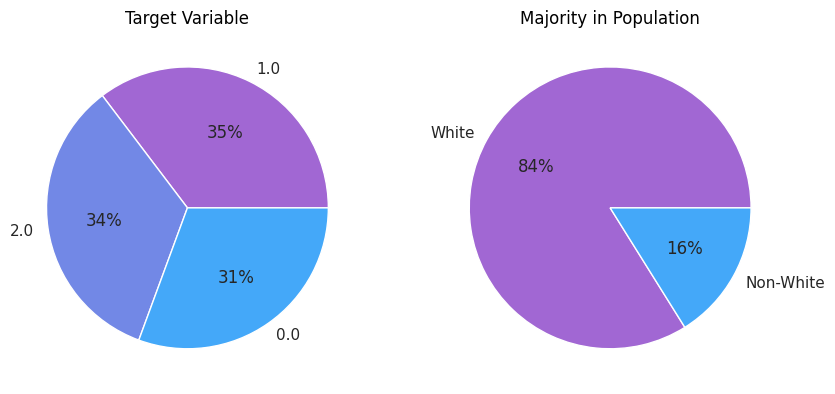

In [3]:
from holisticai.bias.plots import group_pie_plot
import matplotlib.pyplot as plt

# get data 
dataset = dataset.map(lambda sample:{ 'race': 'White' if sample['group_a'] == 1 else 'Non-White'}, vectorized=False)

# group plots
fig, axs =  plt.subplots(1, 2, figsize=(10, 5))
group_pie_plot(dataset['y'], title='Target Variable', ax=axs[0])
group_pie_plot(dataset['race'], title='Majority in Population', ax=axs[1])

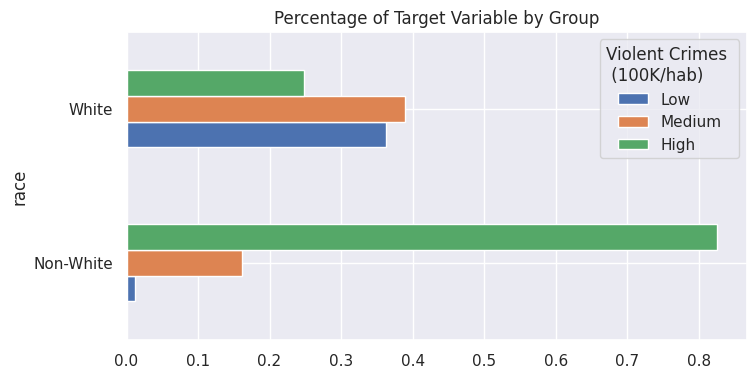

In [4]:
dataset.data.droplevel('features', axis=1).groupby('race')['y'].value_counts(normalize=True).unstack().plot(kind='barh', stacked=False, figsize=(8, 4))
plt.title('Percentage of Target Variable by Group')
plt.legend(title='Violent Crimes \n (100K/hab)', labels = ['Low', 'Medium', 'High'], loc='upper right')
plt.show()

We observe that the majority of records have a higher percentage (84%) of White individuals. Additionally, we notice that for Non-White individuals, the number of instances involving violent crimes is higher in the third quantile compared to the first quantile. This suggests that the model may be biased towards the majority class, as the White group has a more evenly distributed number of instances across the three categories of the target variable. Consequently, we can assume that the model is more likely to predict violent crimes in the third quantile (class 2) for the Non-White group.

## Fairness evaluation

Models trained on imbalanced data tend to learn patterns that are more prevalent in the majority class. In this case, the majority class comprises White individuals, who have a more balanced distribution of instances across all quantiles of violent crimes. This balanced distribution helps the model make more accurate predictions for the White group. However, for the Non-White group, the imbalance in the distribution—especially the higher occurrence of violent crimes in the third quantile—may lead the model to associate Non-White individuals more strongly with higher quantiles of violent crimes. As a result, the model is likely to predict a higher quantile (class 2) of violent crimes for Non-White individuals, reflecting a bias introduced by the imbalanced data.

To evaluate the fairness of the model, we will use the following pipeline:

**Measure Bias in Predictions**: We will train machine learning models and employ a set of bias metrics to assess whether the predictions are biased with respect to the protected attributes.

**Bias Mitigation**: If bias is detected in the predictions, we will apply bias mitigation techniques to enhance the fairness of the model.

**Comparison**: Finally, we will compare the performance and fairness of the original and bias-mitigated models. This comparison will help us understand the trade-offs between accuracy and fairness in this context.

By following these steps, we aim to ensure that our predictive models are both accurate and fair, minimizing any potential biases related to protected attributes.

### Set up the dataset and protected attributes

Holisticai library that are available several preprocessing, inprocessing, and postprocessing bias mitigation strategies . For this study case, we applied: Disparate Impact Remover (preprocessing), Fair Score Classifier (inprocessing), and Linear Programming Debiaser (postprocessing). We use `Pipeline` class to combine the bias mitigation strategy with the classification model in a more straightforward way.

In [5]:
# some imports
from holisticai.bias.metrics import multiclass_bias_metrics
from holisticai.pipeline import Pipeline
from holisticai.bias.mitigation import DisparateImpactRemover
from holisticai.bias.mitigation import LPDebiaserMulticlass
#from holisticai.bias.mitigation import FairScoreClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [6]:
# load the dataset with sex attribute as the protected attribute
dataset = load_dataset('us_crime_multiclass')
train_test = dataset.train_test_split(test_size=0.2, random_state=42)

# get the train and test data
train = train_test['train']
test = train_test['test']

train_test

DatasetDict({
    train: {"dtype": "Dataset", "attributes": {"Number of Rows": 1594, "Features": ["X , y , group_a , group_b , p_attr"]}, "metadata": null},
    test: {"dtype": "Dataset", "attributes": {"Number of Rows": 399, "Features": ["X , y , group_a , group_b , p_attr"]}, "metadata": null}
})

### Measure bias in predictions (without bias mitigation)

In [7]:
# Scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(train['X'])

# Model fit
model = LogisticRegression()
model.fit(X_train, train['y'])

# Model predict
X_test = scaler.transform(test['X'])
y_pred = model.predict(X_test)
# Compute metrics
baseline = multiclass_bias_metrics(test['p_attr'], y_pred, test['y'], metric_type='both')

# Compute accuracy
baseline_accuracy = accuracy_score(test['y'], y_pred)

### Bias mitigation

#### Pre-processing

In [8]:
mitigator = DisparateImpactRemover()

# set pipeline
pipeline = Pipeline(steps=[('scalar', StandardScaler()),("bm_preprocessing", mitigator), ("model", LogisticRegression())])
pipeline.fit(train['X'], train['y'], bm__group_a=train['group_a'], bm__group_b=train['group_b'])

# predict on test set
y_pred = pipeline.predict(test['X'], bm__group_a=test['group_a'], bm__group_b=test['group_b'])

# compute bias metrics
metrics_preprocessing = multiclass_bias_metrics(test['p_attr'], y_pred, test['y'], metric_type='both')

# compute accuracy
accuracy_preprocessing = accuracy_score(test['y'], y_pred)


#### In-processing

In [ ]:
mitigator = FairScoreClassifier(objectives="ba", constraints={}, time_limit=200)

# set pipeline
pipeline = Pipeline(steps=[('scalar', StandardScaler()),("bm_inprocessing", mitigator),])
pipeline.fit(train['X'], train['y'], bm__group_a=train['group_a'], bm__group_b=train['group_b'])

# predict
y_pred = pipeline.predict(test['X'], bm__group_a=test['group_a'], bm__group_b=test['group_b'])

# compute bias metrics
metrics_inprocessing = multiclass_bias_metrics(test['p_attr'], y_pred, test['y'], metric_type='both')

# compute accuracy
accuracy_inprocessing = accuracy_score(test['y'], y_pred)

#### Post-processing

In [ ]:
mitigator = LPDebiaserMulticlass(constraint="EqualizedOpportunity")

# set pipeline
pipeline = Pipeline(steps=[('scalar', StandardScaler()), ("model", model), ("bm_postprocessing", mitigator)])
pipeline.fit(train['X'], train['y'], bm__group_a=train['group_a'], bm__group_b=train['group_b'])

# predict on test set
y_pred = pipeline.predict(test['X'], bm__group_a=test['group_a'], bm__group_b=test['group_b'])

# compute bias metrics
metrics_postprocessing = multiclass_bias_metrics(test['p_attr'], y_pred, test['y'], metric_type='both')

# compute accuracy
accuracy_postprocessing = accuracy_score(test['y'], y_pred)

### Comparison

In [ ]:
# Comparison table of bias metrics

keys = ['Baseline', 'Preprocessing Mitigator', 'Inprocessing Mitigator', 'Postprocessing Mitigator', 'Reference'] 
comparison = pd.concat([baseline['Value'], metrics_preprocessing['Value'], metrics_inprocessing['Value'], metrics_postprocessing], axis=1)
comparison.columns = keys

def highlight_closest(s):
    reference = s['Reference']
    differences = s.drop('Reference').apply(lambda x: abs(x - reference))
    closest = differences.idxmin()
    return ['background-color: mediumseagreen' if x == s[closest] else '' for x in s]

comparison_highlighted = comparison.style.apply(highlight_closest, axis=1)
comparison_highlighted

In [ ]:
# Create a comparison table of accuracy
acc = {
    'Baseline': baseline_accuracy,
    'Preprocessing Mitigator': accuracy_preprocessing,
    'Inprocessing Mitigator': accuracy_inprocessing,
    'Postprocessing Mitigator': accuracy_postprocessing
}

acc_data = pd.DataFrame(acc, index=['Accuracy'])
acc_data.loc['Accuracy'] = acc_data.loc['Accuracy'].apply(lambda x: round(x, 4))
acc_data.loc['Diff. Baseline (%)'] = acc_data.loc['Accuracy'].apply(lambda x: round((x - acc_data.loc['Accuracy']['Baseline']) * 100, 4))
acc_data

The results demonstrate that bias mitigation methods are effective in reducing bias. In this experiment, we observed a significant loss of accuracy for both in-processing and post-processing methods. However, the Disparate Impact Remover method proved to be an exception, successfully reducing bias without a significant loss of accuracy.

## Summary

This study explores bias mitigation in machine learning predictions using the United States Crime Dataset. The dataset encompasses socio-economic data from the 1990 US Census, law enforcement data from the 1990 US Law Enforcement Management and Administrative Statistics (LEMAS) survey, and crime data from the 1995 FBI Uniform Crime Reporting (UCR) program. By integrating these diverse sources, we aimed to understand the patterns and prevalence of crime and the impact of socio-economic and law enforcement factors on crime rates.

The analysis revealed significant bias in the model predictions, particularly against Non-White individuals. The model tended to predict higher quantiles of violent crimes for Non-White individuals, reflecting a bias introduced by the imbalanced data. To address this issue, we implemented various bias mitigation strategies, including pre-processing, in-processing, and post-processing methods.

Our findings indicate that bias mitigation methods are generally effective in reducing bias. However, there is often a trade-off between bias and accuracy. Both in-processing and post-processing methods led to a significant loss of accuracy while reducing bias. In contrast, the Disparate Impact Remover method, a pre-processing technique, successfully reduced bias without a notable decrease in accuracy. This method transforms the input data to reduce the correlation between the protected attribute and the target variable, ensuring less biased and more accurate predictions.

In conclusion, while bias mitigation techniques can enhance the fairness of predictive models, it is crucial to consider the potential trade-offs with model accuracy. By carefully selecting and evaluating bias mitigation methods, we can develop more fair and robust machine learning models that promote fairness and trust in data-driven decision-making processes.